In [90]:
from data_prepare.dataloader import DataLoader
from modeling.neuron import Neuron
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from typing import *
from pathlib import Path
import os
from PIL import Image
from prettytable import PrettyTable, MARKDOWN
def create_markdown_table():
    table = PrettyTable()
    table.set_style(MARKDOWN)
    table.align = 'l'
    return table
def pdprint(*args, **kwargs):
    print("[debug]", *args, **kwargs)
    
def pdtest(actual, expected, *args, **kwargs):
    print("[test][ actual ]", actual, *args, **kwargs)
    print("[test][expected]", expected, *args, **kwargs)
    if actual != expected:
        print("[test][warning!]", "=== check this! ===", *args, **kwargs)

In [91]:
# HOME = Path.cwd()
# dataset_root = HOME / "dataset"
# dataset_root.mkdir(parents=True, exist_ok=True)
# neu_src_path = HOME / "modeling" / "neuron.py"
# neu_store_path = dataset_root / "neuron.npy"
# if not neu_store_path.exists():
#     neu = Neuron()  
#     np.save(str(neu_store_path), neu)    
# else:
#     if os.path.getmtime(neu_store_path) < os.path.getmtime(neu_src_path):
#         os.remove(neu_store_path)
#         neu = Neuron()  
#         np.save(str(neu_store_path), neu)  
#     else:
#         neu = np.load(str(neu_store_path), allow_pickle=True).item()
neu = Neuron()

======= Loading data =======
Loading matlab file from /home/kidrain61/code/ME-XJX-2023S/math-modeling-competition/Math_Modeling/dataset/infer_results_1.mat
Loading matlab file from /home/kidrain61/code/ME-XJX-2023S/math-modeling-competition/Math_Modeling/dataset/infer_results_2.mat
Loading matlab file from /home/kidrain61/code/ME-XJX-2023S/math-modeling-competition/Math_Modeling/dataset/infer_results_id_1.mat
Loading matlab file from /home/kidrain61/code/ME-XJX-2023S/math-modeling-competition/Math_Modeling/dataset/infer_results_id_2.mat
Loading excel file from /home/kidrain61/code/ME-XJX-2023S/math-modeling-competition/Math_Modeling/dataset/Infer results 1/brain_region_name1.xlsx
Loading excel file from /home/kidrain61/code/ME-XJX-2023S/math-modeling-competition/Math_Modeling/dataset/Infer results 2/brain_region_name2.xlsx


/home/kidrain61/anaconda3/envs/da/lib/python3.10/site-packages/scipy/io/matlab/_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [92]:
def plot_spikes_time_series(
    neuron, region_ids: List = [], stage_idx: int = -1, **kwargs
):
    """Plot the time series of spikes of neurons in stage(s).

    Args:
        save_pic (bool, optional): Save the picture or not. Defaults to False.
    """
    if region_ids == []:
        region_ids = neuron.categories
    save_pic = kwargs.get("save_pic", False)

    stages = {
        -1: (0, neuron.obs_len),
        0: (0, 1000),
        1: (1000, 7000),
        2: (7000, neuron.obs_len),
    }

    # select by region_ids

    region_mean_spikes = {}
    for region_id in neuron.categories:
        selection = neuron.region_id == region_id
        region_mean_spikes[region_id] = np.mean(
            neuron.data.global_S[
                selection, stages[stage_idx][0] : stages[stage_idx][1]
            ],
            axis=0,
        )
    
    # visualize
    all_region_mean_spikes = np.array(list(region_mean_spikes.values()))
    # pdprint(all_region_mean_spikes.shape)
    # pdprint(all_region_mean_spikes)
    max_region_mean_spike = np.max(all_region_mean_spikes)
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.set_ylim(0, max_region_mean_spike)
    for region_id in region_ids:
        spikes = region_mean_spikes[region_id]
        ax.plot(
            np.arange(spikes.shape[0]) * 0.1,
            spikes,
            c=neuron.cmap[region_id],
            label=f"Region {region_id}",
            alpha=0.5,
        )
    
    ax.set_title(
        f"Spikes Time Series of Neurons\nin Regions {region_ids if region_ids != [] else 'All'}\n\
        across {f'Stage {stage_idx+1}' if stage_idx != -1 else 'All Stages'}"
    )
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Spikes")
    if not save_pic:
        fig.show()
    else:
        from pathlib import Path

        pic_root = Path.cwd() / "pics" / "时区图"
        pic_root.mkdir(parents=True, exist_ok=True)
        file_path = pic_root / f"times_{'-'.join(map(str, region_ids))}.png"
        plt.savefig(file_path)
        print(f"Created {str(file_path)}")


In [93]:
# plot_spikes_time_series(neu, region_ids=[], save_pic=True)
# for region_id in neu.categories:
#     plot_spikes_time_series(neu, region_ids=[region_id], save_pic=True)
#     # break

/home/kidrain61/code/ME-XJX-2023S/math-modeling-competition/Math_Modeling/modeling/neuron.py:144: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


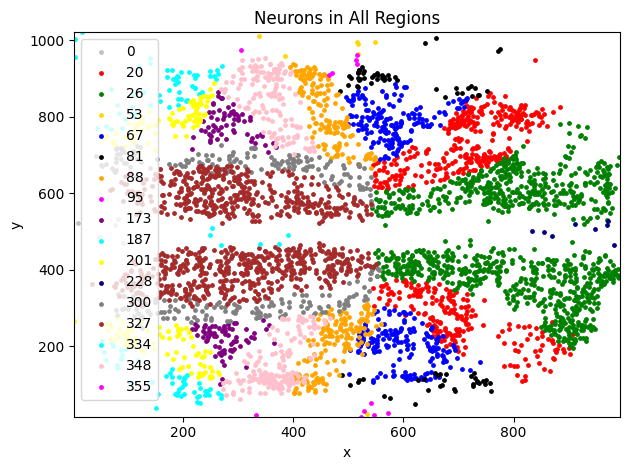

In [94]:
neu.plot_brain_regions()

In [132]:
def plot_active_regions_by_steps(neuron, abs_threshold=0.01, rel_threshold=0.8, step=100, *args, **kwargs):
    """
    绘制每一时间步的活跃区域随时间变化的图像

    Args:
    ----
    neuron: NeuronData
        NeuronData 类型的对象，包含神经元数据
    abs_threshold: float
        绝对阈值，指尖峰强度大于等于该值的被认为是尖峰，单位为微伏（uV）
    rel_threshold: float
        相对阈值，指尖峰强度在所有样本中的排名大于等于该值的被认为是尖峰，
        用于计算活跃区域，取值范围为 [0, 1]，默认为 0.8
    step: int
        时间步长，单位为毫秒（ms），默认为 100
    *args, **kwargs:
        可变参数和关键字参数，用于传递给 neuron.plot_brain_regions() 函数

    Returns:
    -------
    None
    """
    # 获取是否保存 GIF 图像的参数
    save_gif = kwargs.pop("save_gif", False)
    
    # 将神经元数据按照区域分组，并计算每个区域的平均尖峰强度
    region_spikes = neuron.devide_by_regions(neuron.data.global_S)
    region_all_mean_spikes = {region_id: np.mean(region_spikes[region_id], axis=0) for region_id in neuron.categories}
    
    
    # 计算每个区域的平均尖峰强度，并按照时间步长分组
    max_step_num = int(neuron.obs_len * 0.1 // step)
    max_obs_len = step * 10 * max_step_num
    region_step_mean_spikes = {region_id: np.mean(region_all_mean_spikes[region_id][:max_obs_len].reshape(-1, step * 10), axis=1) for region_id in neuron.categories}

    # pdprint(region_all_mean_spikes[0].shape)
    # pdprint(region_all_mean_spikes[0][:max_obs_len].shape)
    # pdprint(region_all_mean_spikes[0][:max_obs_len].reshape(step * 10, -1).shape)
    # pdtest(region_step_mean_spikes[0].shape, (14,))
    
    # 各脑区时间步内平均尖峰强度随时间变化的图像
    fig, ax = plt.subplots(len(neuron.categories,figsize=(14, 17))
    for region_idx, region_id in enumerate(neuron.categories):
        # ax.scatter(np.arange(max_step_num) + 0.5, np.repeat(region_idx, max_step_num), c=neuron.cmap[region_id], s = region_step_mean_spikes[region_id]*1000)
        ax = fig.add_subplot()
    ax.set_xticks(np.arange(max_step_num))
    ax.set_xticklabels(np.arange(max_step_num) * step)
    ax.set_xlabel("Time (ms)")
    ax.set_yticks(np.arange(len(neuron.categories)))
    ax.set_yticklabels(neuron.categories)
    ax.set_ylabel("Region ID")
    ax.set_title(f"{step} ms Time Step Mean Spikes of Regions across Time")
    fig.show()
    
    # 在每个时间步中，找到活跃区域
    # 将每个区域的平均尖峰强度按照升序排列，取排名前 20% 的区域作为活跃区域
    region_activities_descend_in_steps = [] # step_idx -> (region_id, mean_spike)
    for i in range(max_step_num):
        region_activities = np.array([(region_id, mean_spikes[i]) for region_id, mean_spikes in region_step_mean_spikes.items()])
        # pdprint(region_mean_spikes) # v
        region_activities_descend = np.flip(region_activities[region_activities[:, 1].argsort()], axis=0)
        # pdprint(region_ids_mean_spikes_descend)
        region_activities_descend_in_steps.append(region_activities_descend)
        
    # for step_idx, step_region_activities_descend in enumerate(region_activities_descend_in_steps):
        
    
    
    # 根据 active_regions_in_steps 调用 neuron.plot_brain_regions() 绘制活跃区域随时间步变化的图像
    # 每个时间步都调用 neuron.plot_brain_regions() 函数绘制活跃区域随时间步变化的图像
    if save_gif:
    # 如果要保存为 GIF 图像，首先创建一个空的图像路径序列 image_path_sequence
        image_path_sequence = []
    # pdprint(active_region_ids_in_steps) # x
    num_active_regions = int(region_activities_descend.shape[0] * (1 - rel_threshold))
    for step_idx, step_region_activities_descend in enumerate(region_activities_descend_in_steps):
        # 计算相对阈值对应的区域数量
        top_step_region_activities_descend = step_region_activities_descend[:num_active_regions]
        # pdprint(region_ids_mean_spikes_descend)
        # pdprint(step_region_activities) # x
        # 根据时间步长计算时间段的开始和结束时间，用于设置图像标题
        start_time = step_idx * step
        end_time = (step_idx + 1) * step
        title = f"Top {int((1-rel_threshold)*100)}% Active Regions in [{start_time},{end_time}) ms"
        labels = [f"{int(top_step_region_activities_descend[idx][0])} ({float(top_step_region_activities_descend[idx][1]):.6f})" for idx in range(top_step_region_activities_descend.shape[0])]
        region_ids = top_step_region_activities_descend[:, 0]
        
        # 为保存图像设置路径和文件名
        save_dir = Path.cwd() / f"pics/各时段活跃区域图/rel_threshold={rel_threshold}"
        save_path = save_dir / f"{title.lower().replace(' ', '-')}.png"
        
        # 调用 neuron.plot_brain_regions() 函数绘制活跃区域随时间步变化的图像，并保存图像
        neuron.plot_brain_regions(list(region_ids),
                                title=title,
                                labels=labels,
                                save_path=save_path,
                                *args, **kwargs)
        
        # 如果要保存为 GIF 图像，则将图像路径添加到 image_path_sequence 中
        if save_gif:
            image_path_sequence.append(save_path)

    # 如果要保存为 GIF 图像，则将图像路径序列中的所有图像打开并保存为 GIF 图像
    if save_gif:
        # 打开所有的 PNG 图像文件并将其添加到图像序列中
        image_sequence = []
        for image_path in image_path_sequence:
            image = Image.open(image_path)
            image_sequence.append(image)

        # 保存图像序列为 GIF 图像文件
        gif_basename = f"Top {int((1-rel_threshold)*100)}% Active Regions Throughout the Entire Process By {step} ms Step".lower().replace(' ', '-')
        image_sequence[0].save(save_dir / f'{gif_basename}.gif', save_all=True, append_images=image_sequence[1:], duration=200, loop=0)


/tmp/ipykernel_702/3152536025.py:52: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


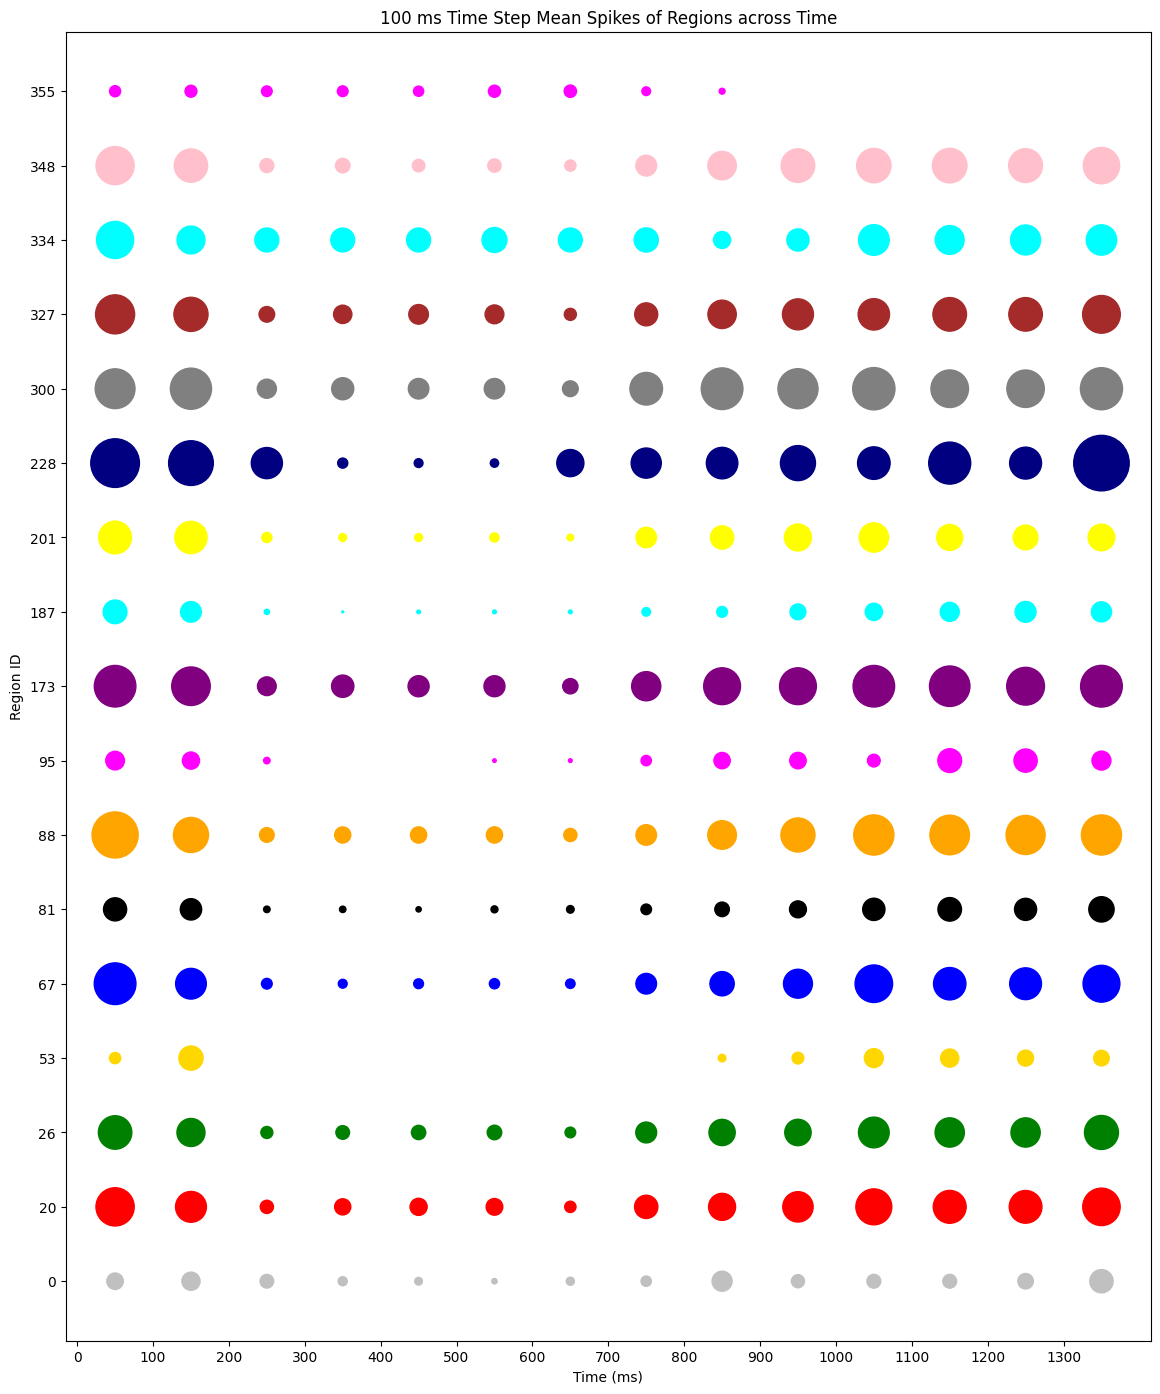

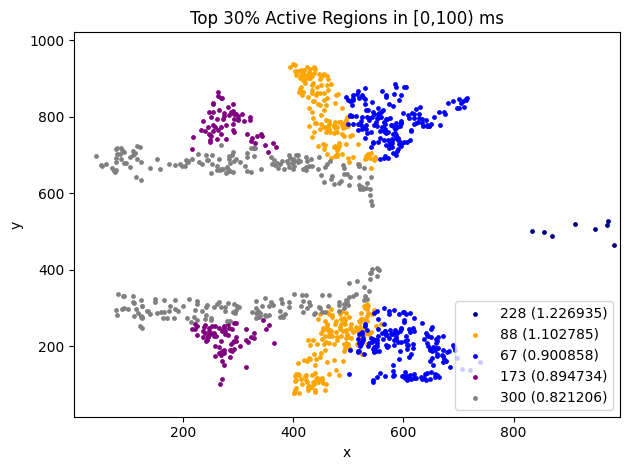

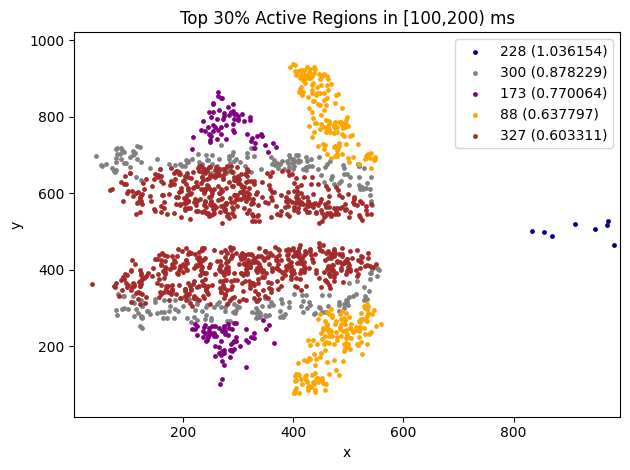

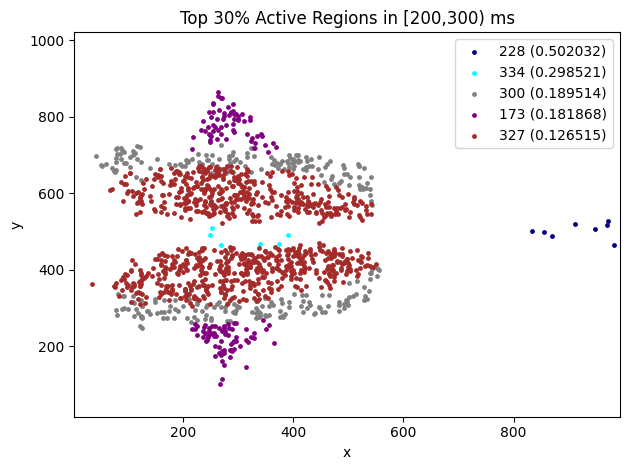

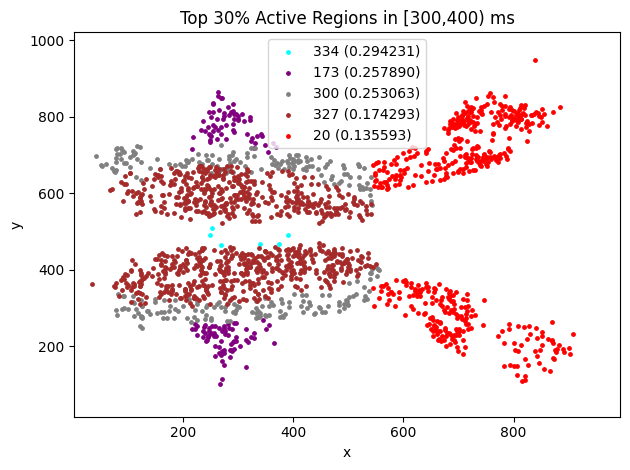

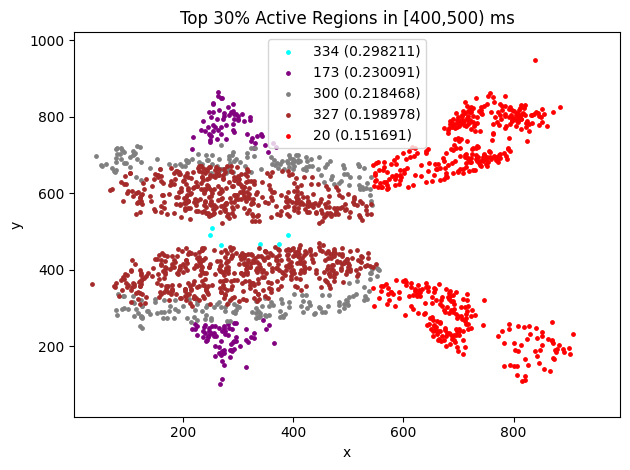

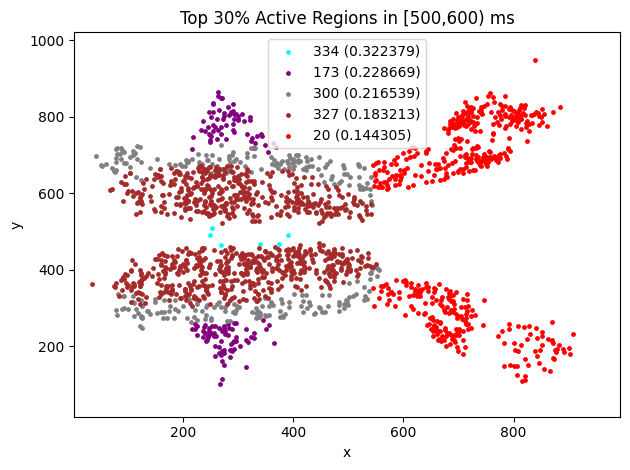

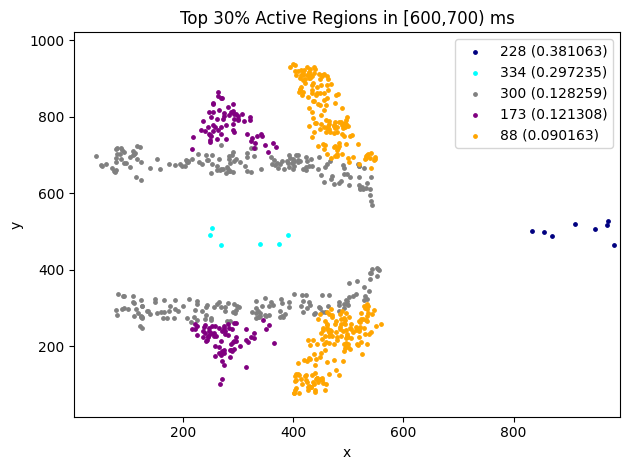

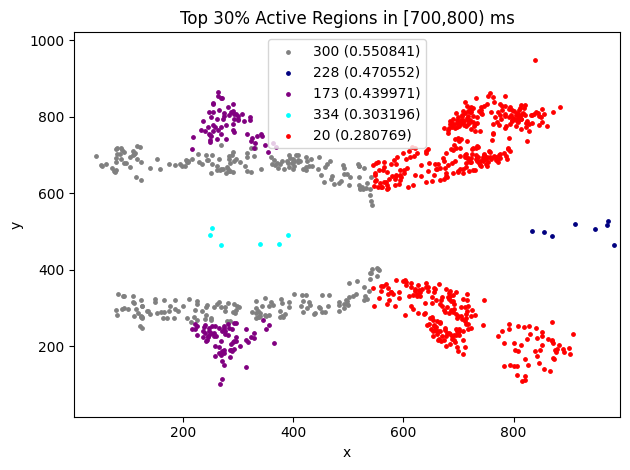

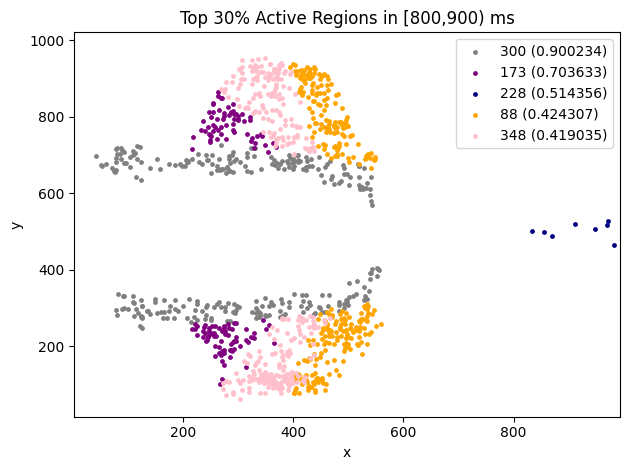

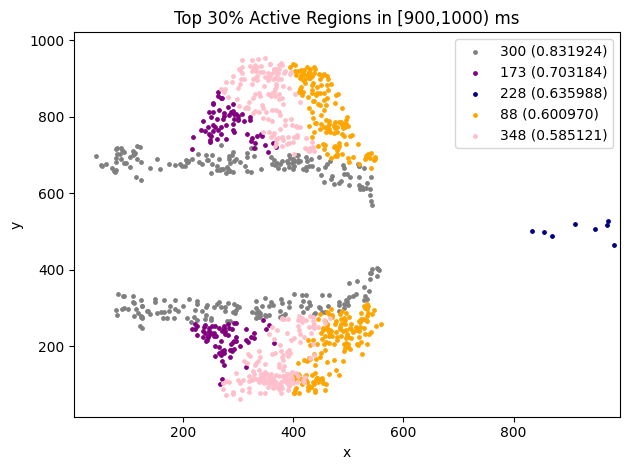

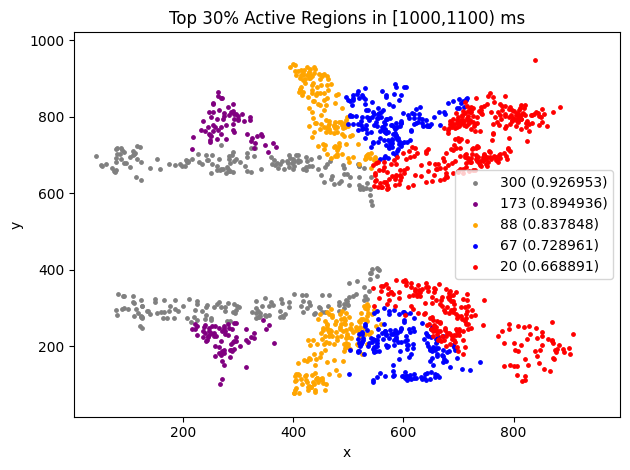

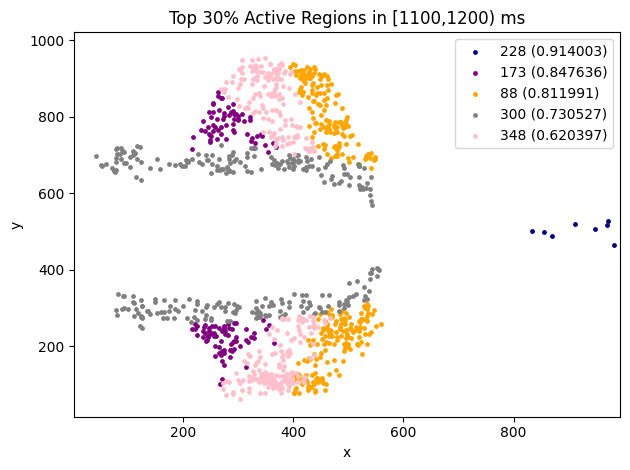

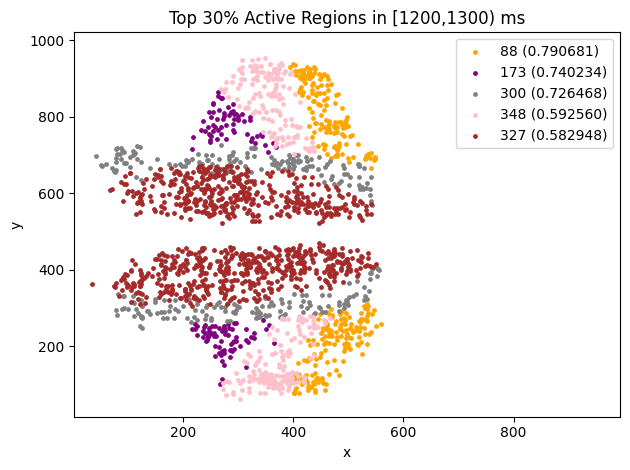

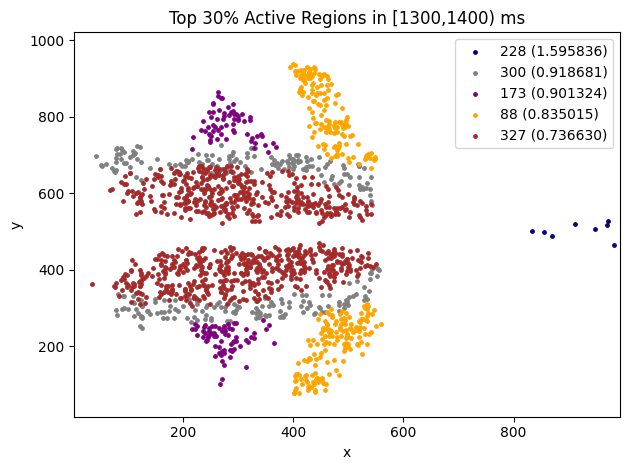

In [133]:
plot_active_regions_by_steps(neu, rel_threshold=0.7, save_pic = True, save_gif=True)

# Test

In [112]:
print(neu.categories)

[  0  20  26  53  67  81  88  95 173 187 201 228 300 327 334 348 355]


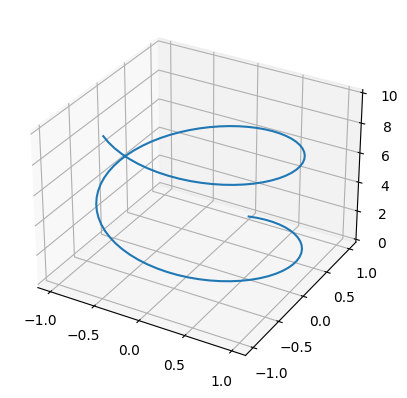

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# 生成随机数据
t = np.linspace(0, 10, 100)
x = np.sin(t)
y = np.cos(t)
z = t

# 创建 3D 坐标轴
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制三维曲线
ax.plot(x, y, z)

# 显示图像
plt.show()


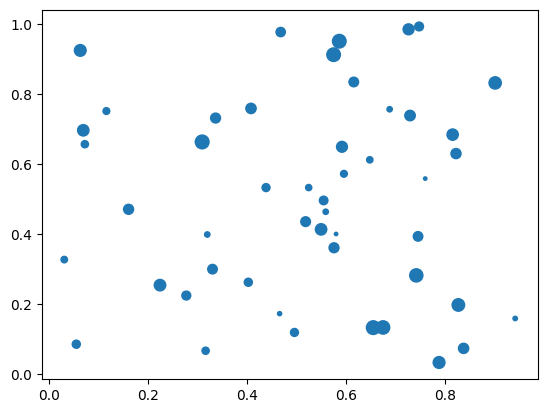

In [115]:
import matplotlib.pyplot as plt
import numpy as np

# 生成随机数据
x = np.random.rand(50)
y = np.random.rand(50)

# 生成随机大小
sizes = np.random.randint(5, 100, 50)

# 绘制散点图
plt.scatter(x, y, s=sizes)

# 显示图像
plt.show()


/tmp/ipykernel_702/599194437.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues')


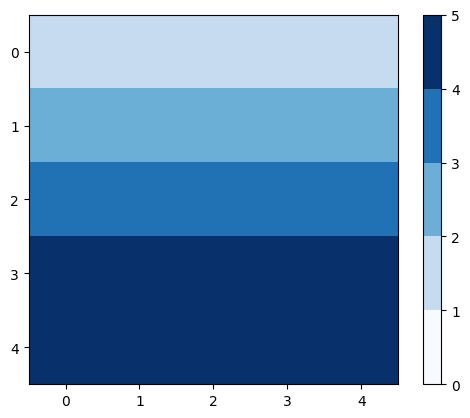

In [97]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import BoundaryNorm

# 创建二维数组，每一行包含相同的数值，但不同行之间的数值不同
data = np.array([
    [1, 1, 1, 1, 1],
    [2, 2, 2, 2, 2],
    [3, 3, 3, 3, 3],
    [4, 4, 4, 4, 4],
    [5, 5, 5, 5, 5]
])

# 定义边界
bounds = [0, 1, 2, 3, 4, 5]

# 定义颜色映射
cmap = plt.cm.get_cmap('Blues')

# 创建颜色规范化对象
norm = BoundaryNorm(bounds, cmap.N)

# 绘制方格热力图
plt.imshow(data, cmap=cmap, norm=norm)

# 添加颜色条
plt.colorbar()

# 显示图像
plt.show()


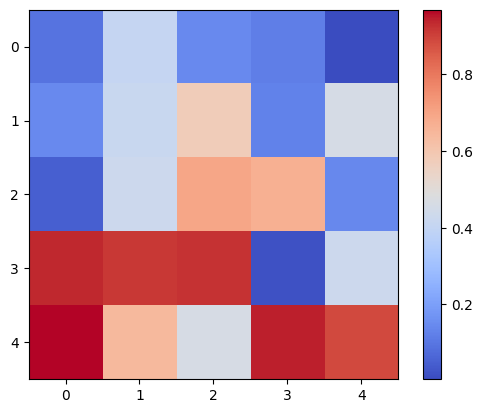

In [98]:
import matplotlib.pyplot as plt
import numpy as np

# 创建随机数据
data = np.random.rand(5, 5)

# 绘制热力图
plt.imshow(data, cmap='coolwarm', interpolation='nearest')

# 添加颜色条
plt.colorbar()

# 显示图像
plt.show()


In [99]:
import numpy as np

# 创建一维数组
x = np.array([1, 2, 3])
y = np.array([4, 5, 6])

# 生成二维网格
xx, yy = np.meshgrid(x, y)

# 打印结果
print(xx)
print(yy)


[[1 2 3]
 [1 2 3]
 [1 2 3]]
[[4 4 4]
 [5 5 5]
 [6 6 6]]


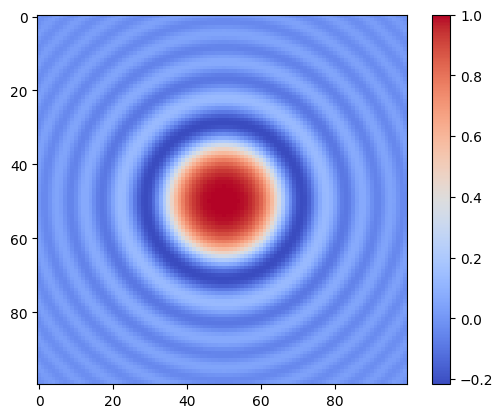

In [100]:
import matplotlib.pyplot as plt
import numpy as np

# 创建数据
x = np.arange(-5, 5, 0.1)
y = np.arange(-5, 5, 0.1)
xx, yy = np.meshgrid(x, y)
z = np.sin(xx**2 + yy**2) / (xx**2 + yy**2)

# 绘制热力图
plt.imshow(z, cmap='coolwarm', interpolation='nearest')

# 添加颜色条
plt.colorbar()

# 显示图像
plt.show()


In [101]:
a = np.array([1,2,3,4])
a1 = a.reshape(2, -1)
print(a1)

[[1 2]
 [3 4]]


In [102]:
print(neu.data.global_C.shape)
print(neu.data.global_C)
print(neu.data.global_S.shape)
print(neu.data.global_S)

(4089, 14122)
[[ 12.37011534  36.93434802  21.29536827 ...  -1.10552859  10.66261553
   -3.73683308]
 [ 13.47559855  15.01032749   1.92428086 ...  -6.08695005  -0.60503874
    1.44404632]
 [ -5.95775196  -4.76703187   2.8900642  ...  19.23593501  14.68726285
    2.58135864]
 ...
 [ -3.2208775  -12.1435502   -6.65330803 ...  13.77693611   5.32214791
    9.69892663]
 [ 14.64881158  17.83683823  14.96797443 ...  -1.01291419  -1.7322658
   -4.90098349]
 [ 12.04398696   6.51977491  13.0683973  ...  -2.08480474   2.78363892
   -5.25854414]]
(4089, 14122)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


[0. 0. 0. ... 0. 0. 0.]
(array([  309,   310,   762,  1119,  1146,  1147,  1149,  1324,  1407,
        1408,  1478,  1484,  1544,  1678,  2832,  7950,  7981,  9435,
        9463,  9465,  9647,  9649,  9710,  9712, 10013, 10907, 11161,
       11162, 11170, 11173, 11174, 11510, 11516, 11517, 11756, 11768,
       11835, 11836, 11840, 11850, 12031, 12042, 12051, 12052, 12053,
       12404, 12405, 12595, 12748, 12793, 12796, 12798, 12799, 12842,
       12977, 12978, 12979, 12980, 13079, 13123, 13125, 13218, 13522,
       13525, 13749, 13750, 13949, 13992, 13993, 13996]),)
[ 47.36449685  40.59650701 103.65820377  48.07468514  48.67469747
  60.13606555  71.51787514  46.87758803  49.08645974  69.60283892
  49.08648559  82.61187338  39.99647024  34.03315742  42.41149009
  35.42261237  46.0794833   36.72645472  77.21096263  46.51568101
  50.40363097  52.94235293  48.15483915  59.99047878  51.34242755
  67.58005964  70.30113306  50.58473696  77.54036719  44.48733481
 103.03504385  67.9406643   84

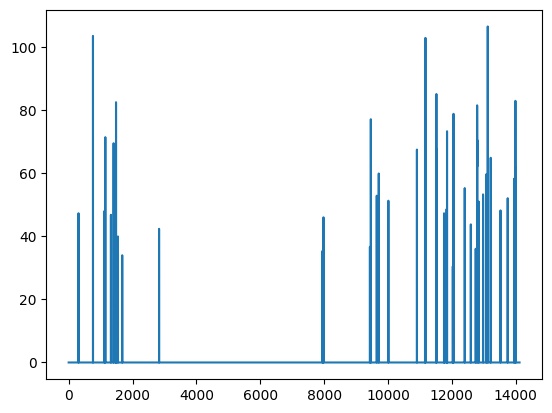

In [103]:
neuron_idx = 2
spike_units = neu.data.global_S[neuron_idx]
spike_times = np.nonzero(spike_units)
spike_durations = spike_units[spike_times]

print(spike_units)
print(spike_times)
print(spike_durations)
print(np.count_nonzero(spike_units))
plt.plot(spike_units)